# Dengue Outbreak Simulator Emulation with GP

### Import Libraries

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Specify Paths, N, Response Vars


In [2]:
train_path = 'Dengue/Data/Simulation/Duration/DD-AML-train-LHS-5000-condSim-logDuration.txt'
test_path = 'Dengue/Data/Simulation/Duration/DD-AML-test-LHS-10000-condSim-logDuration.txt'

In [3]:
number_data_points = 1000

# ---- possible response variable options: ----

response_var = 'log duration'

#response_var = 'maxIncidence'

#response_var = 'outbreakProb'
# can't calculate from this dataset? because each row corresponds to averages from 100 simulation runs

#response_var = 'epidemicSize' 
# they did not use this in the paper, used outbreak probability
# "proportion of simulation runs in which more than 0.1% of the population becomes infected"

In [4]:
# read data
train_set = pd.read_csv(train_path, sep = "\t")
test_set = pd.read_csv(test_path, sep = "\t")

In [5]:
# take log of duration
train_set['log duration'] = np.log(train_set['duration'])  
test_set['log duration'] = np.log(test_set['duration'])

# drop unnecessary columns
drop_cols = [ 'simRound', 'simID']

possible_response_vars = ['log duration', 'duration', 'epidemicSize', 'maxIncidence','sd_maxIncidence', 'sd_epidemicSize', 'sd_duration']

for item in possible_response_vars:
    if item != response_var:
        drop_cols.append(item)

train_set = train_set.drop(drop_cols, axis=1)
test_set = test_set.drop(drop_cols, axis=1)

# select first n from train, test
Xtrain_df = train_set.drop(response_var, axis=1)[0:number_data_points]
Xtrain = Xtrain_df.to_numpy()
Ytrain_df = train_set[response_var][0:number_data_points]
Ytrain = Ytrain_df.to_numpy().reshape(-1, 1)

Xtest_df = test_set.drop(response_var, axis=1)[0:number_data_points]
Xtest = Xtest_df.to_numpy()
Ytest_df = test_set[response_var][0:number_data_points]
Ytest = Ytest_df.to_numpy().reshape(-1, 1)

In [6]:
# define function to reload the data and reset, so that I can call it each time I model.

def reset_data(num = 1000, res_var=response_var, df = False): 

    # read data
    train_set = pd.read_csv(train_path, sep = "\t")
    test_set = pd.read_csv(test_path, sep = "\t")

    # take log of duration
    train_set['log duration'] = np.log(train_set['duration'])  
    test_set['log duration'] = np.log(test_set['duration'])

    # drop unnecessary columns
    drop_cols = [ 'simRound', 'simID']

    possible_response_vars = ['log duration', 'duration', 'epidemicSize', 'maxIncidence','sd_maxIncidence', 'sd_epidemicSize', 'sd_duration']

    for item in possible_response_vars:
        if item != res_var:
           drop_cols.append(item)

    train_set = train_set.drop(drop_cols, axis=1)
    test_set = test_set.drop(drop_cols, axis=1)

    # size check
    num = min(num, len(train_set), len(test_set))


    # select random n points
    train_subset = train_set.sample(n=num, random_state=22)
    Xtrain_df = train_subset.drop(res_var, axis=1)
    Xtrain = Xtrain_df.to_numpy()
    Ytrain_df = train_subset[res_var]
    Ytrain = Ytrain_df.to_numpy().reshape(-1, 1)

    test_subset = test_set.sample(n=num, random_state=22)
    Xtest_df = test_subset.drop(res_var, axis=1)
    Xtest = Xtest_df.to_numpy()
    Ytest_df = test_subset[res_var]
    Ytest = Ytest_df.to_numpy().reshape(-1, 1)

    if df:
        return Xtrain_df, Xtest_df, Ytrain_df, Ytest_df
    else:
        return Xtrain, Xtest, Ytrain, Ytest

In [7]:
print("Displaying Original Training Data:")
train_set.head()

Displaying Original Training Data:


alphaRest  alphaAmp  alphaShift  infTicksCounts  avgVisitsCounts  pVisits  \
0   0.013191    0.5959      0.7999          4.0050           1.6668  0.61493   
1   0.026691    0.8901      0.1425          4.7738           4.4996  0.29885   
2   0.013959    0.7015      0.5965          5.0506           2.1236  0.52673   
3   0.012351    0.5541      0.0989          5.6122           1.2948  0.08969   
4   0.014151    0.7141      0.6015          4.2950           2.5860  0.68045   

   propSocialVisits  locPerSGCount  log duration  
0            0.9667         2.8297      0.612212  
1            0.3457         2.9893      0.283951  
2            0.1029        19.0329      0.772498  
3            0.7879        11.8813      0.663139  
4            0.4663        16.2437      0.789539

In [8]:
print("Displaying (Abbreviated) XTrain Data:")
Xtrain_df.head()

Displaying (Abbreviated) XTrain Data:


alphaRest  alphaAmp  alphaShift  infTicksCounts  avgVisitsCounts  pVisits  \
0   0.013191    0.5959      0.7999          4.0050           1.6668  0.61493   
1   0.026691    0.8901      0.1425          4.7738           4.4996  0.29885   
2   0.013959    0.7015      0.5965          5.0506           2.1236  0.52673   
3   0.012351    0.5541      0.0989          5.6122           1.2948  0.08969   
4   0.014151    0.7141      0.6015          4.2950           2.5860  0.68045   

   propSocialVisits  locPerSGCount  
0            0.9667         2.8297  
1            0.3457         2.9893  
2            0.1029        19.0329  
3            0.7879        11.8813  
4            0.4663        16.2437

Displaying Pairplot for All Original Training Data


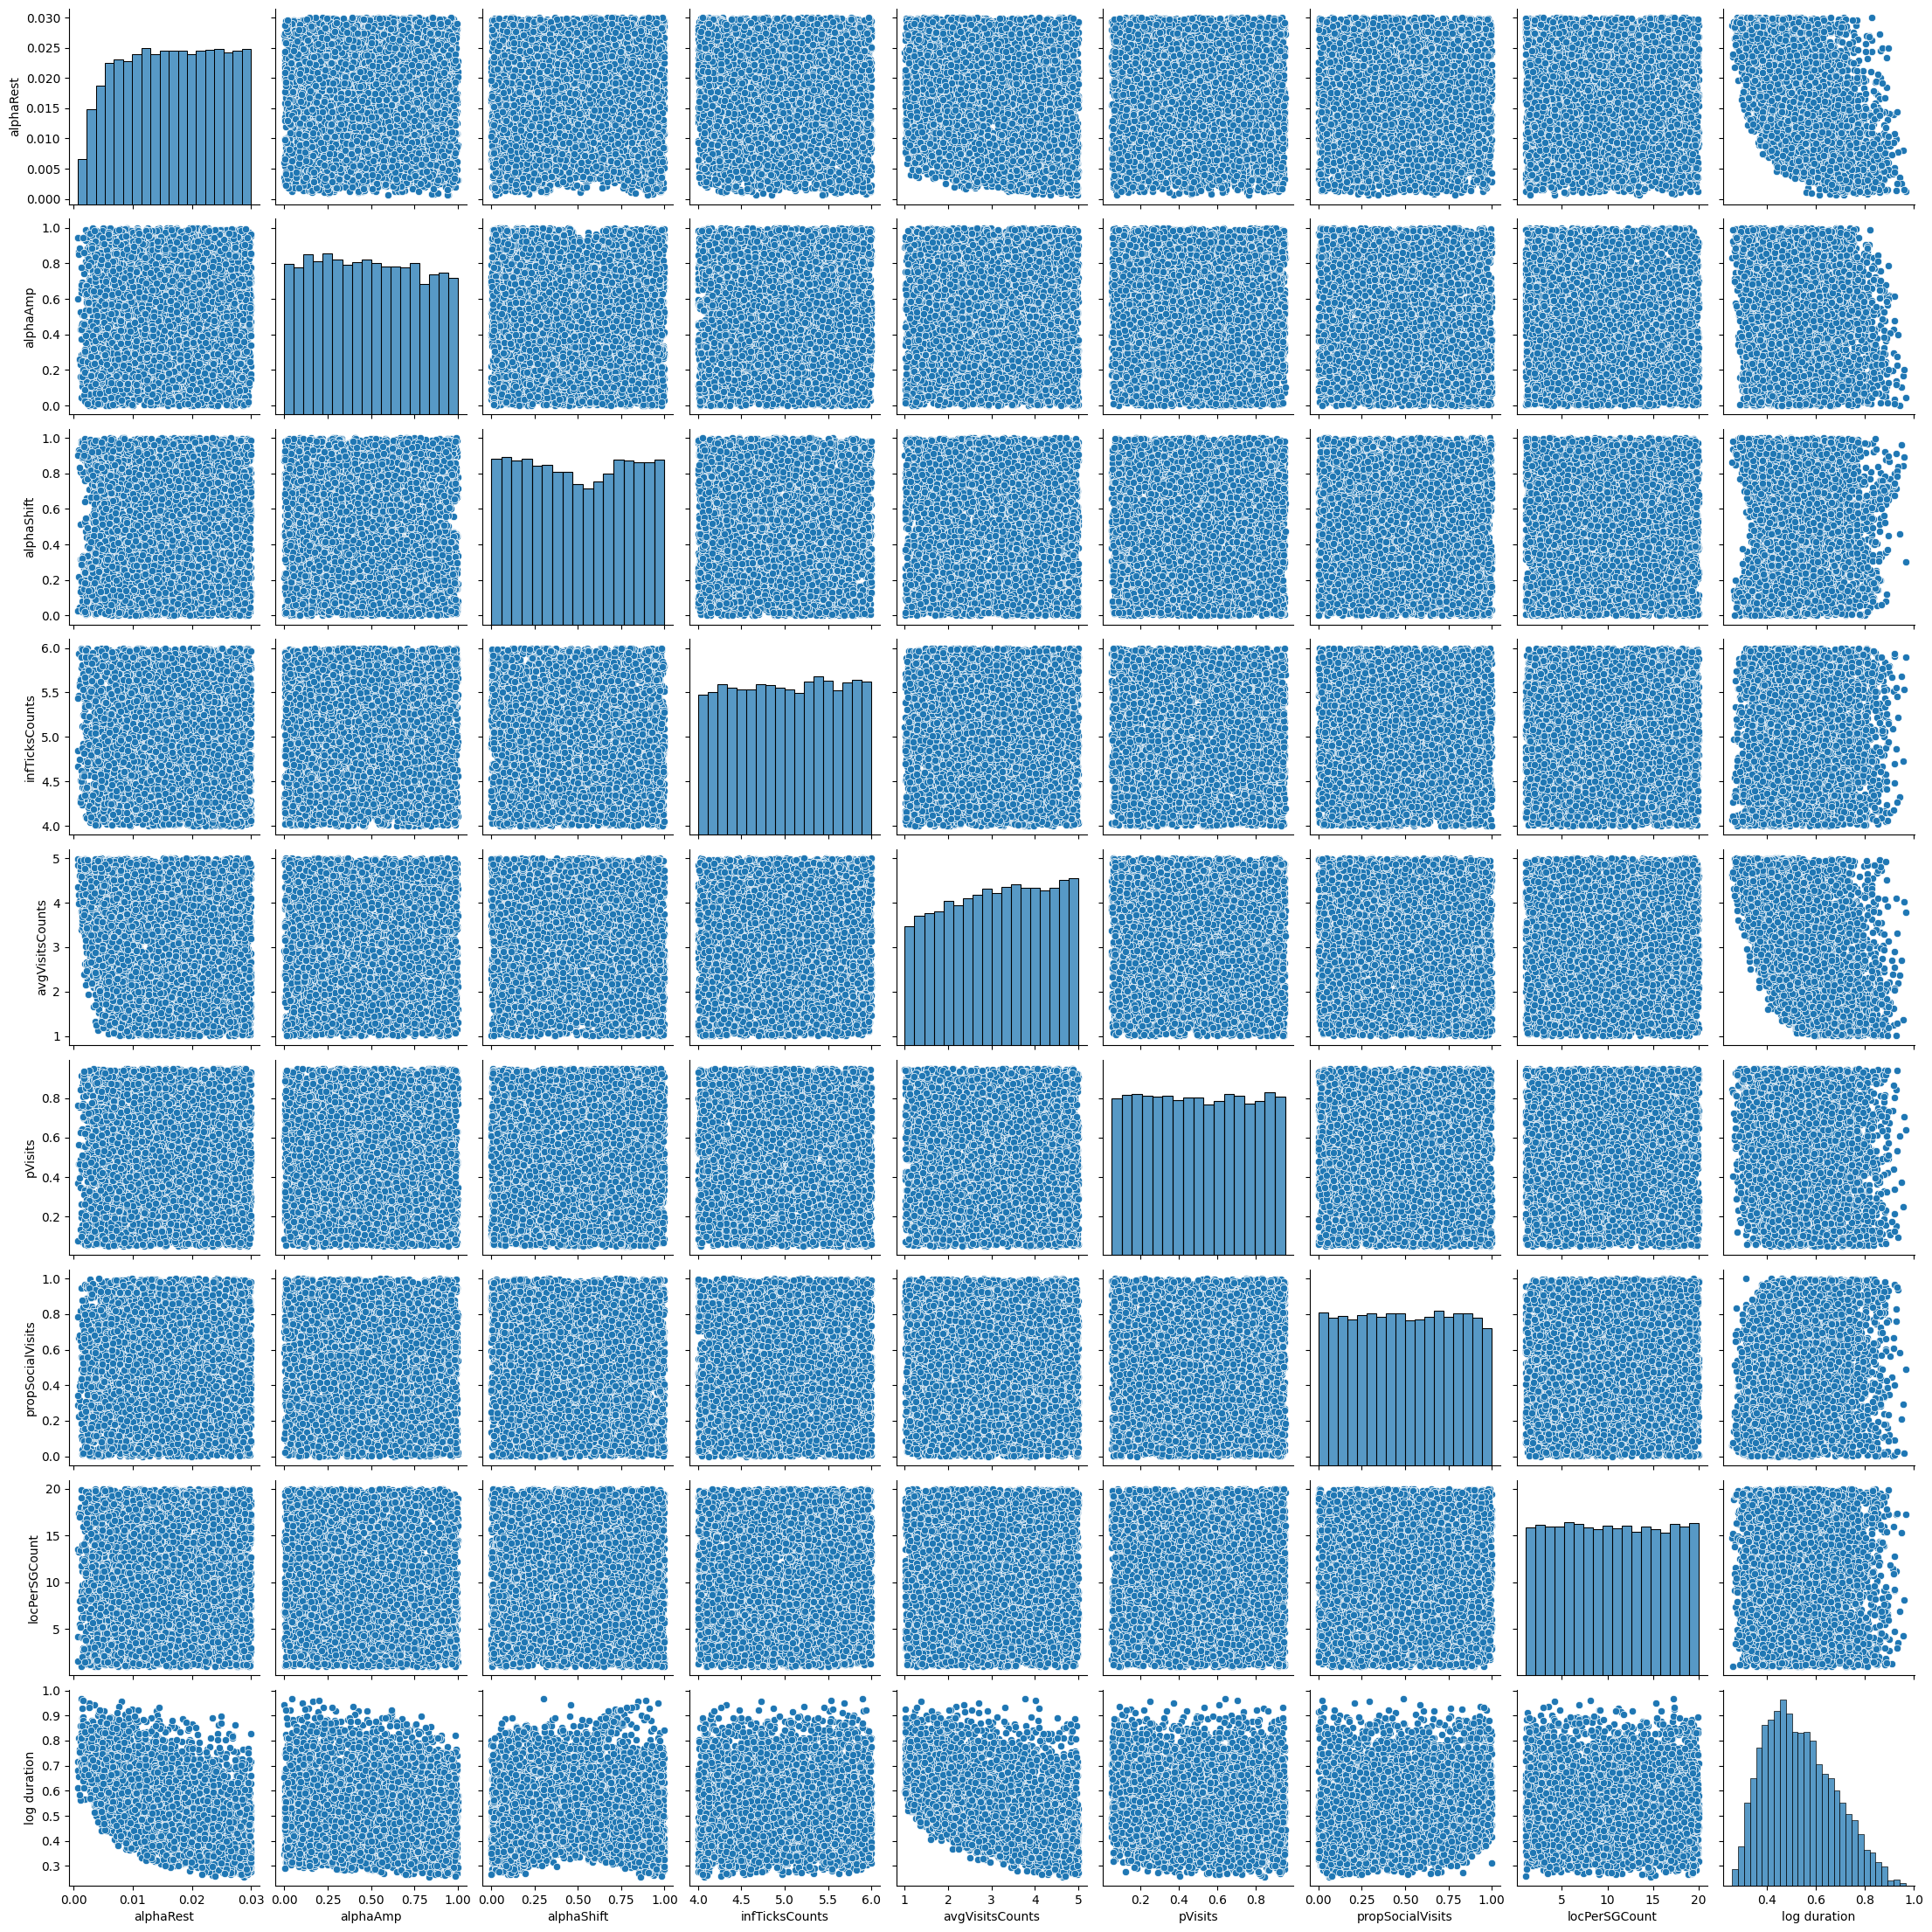

In [9]:
print("Displaying Pairplot for All Original Training Data")
sns.pairplot(train_set)

Displaying Pairplot for (Abbreviatd) Training Data


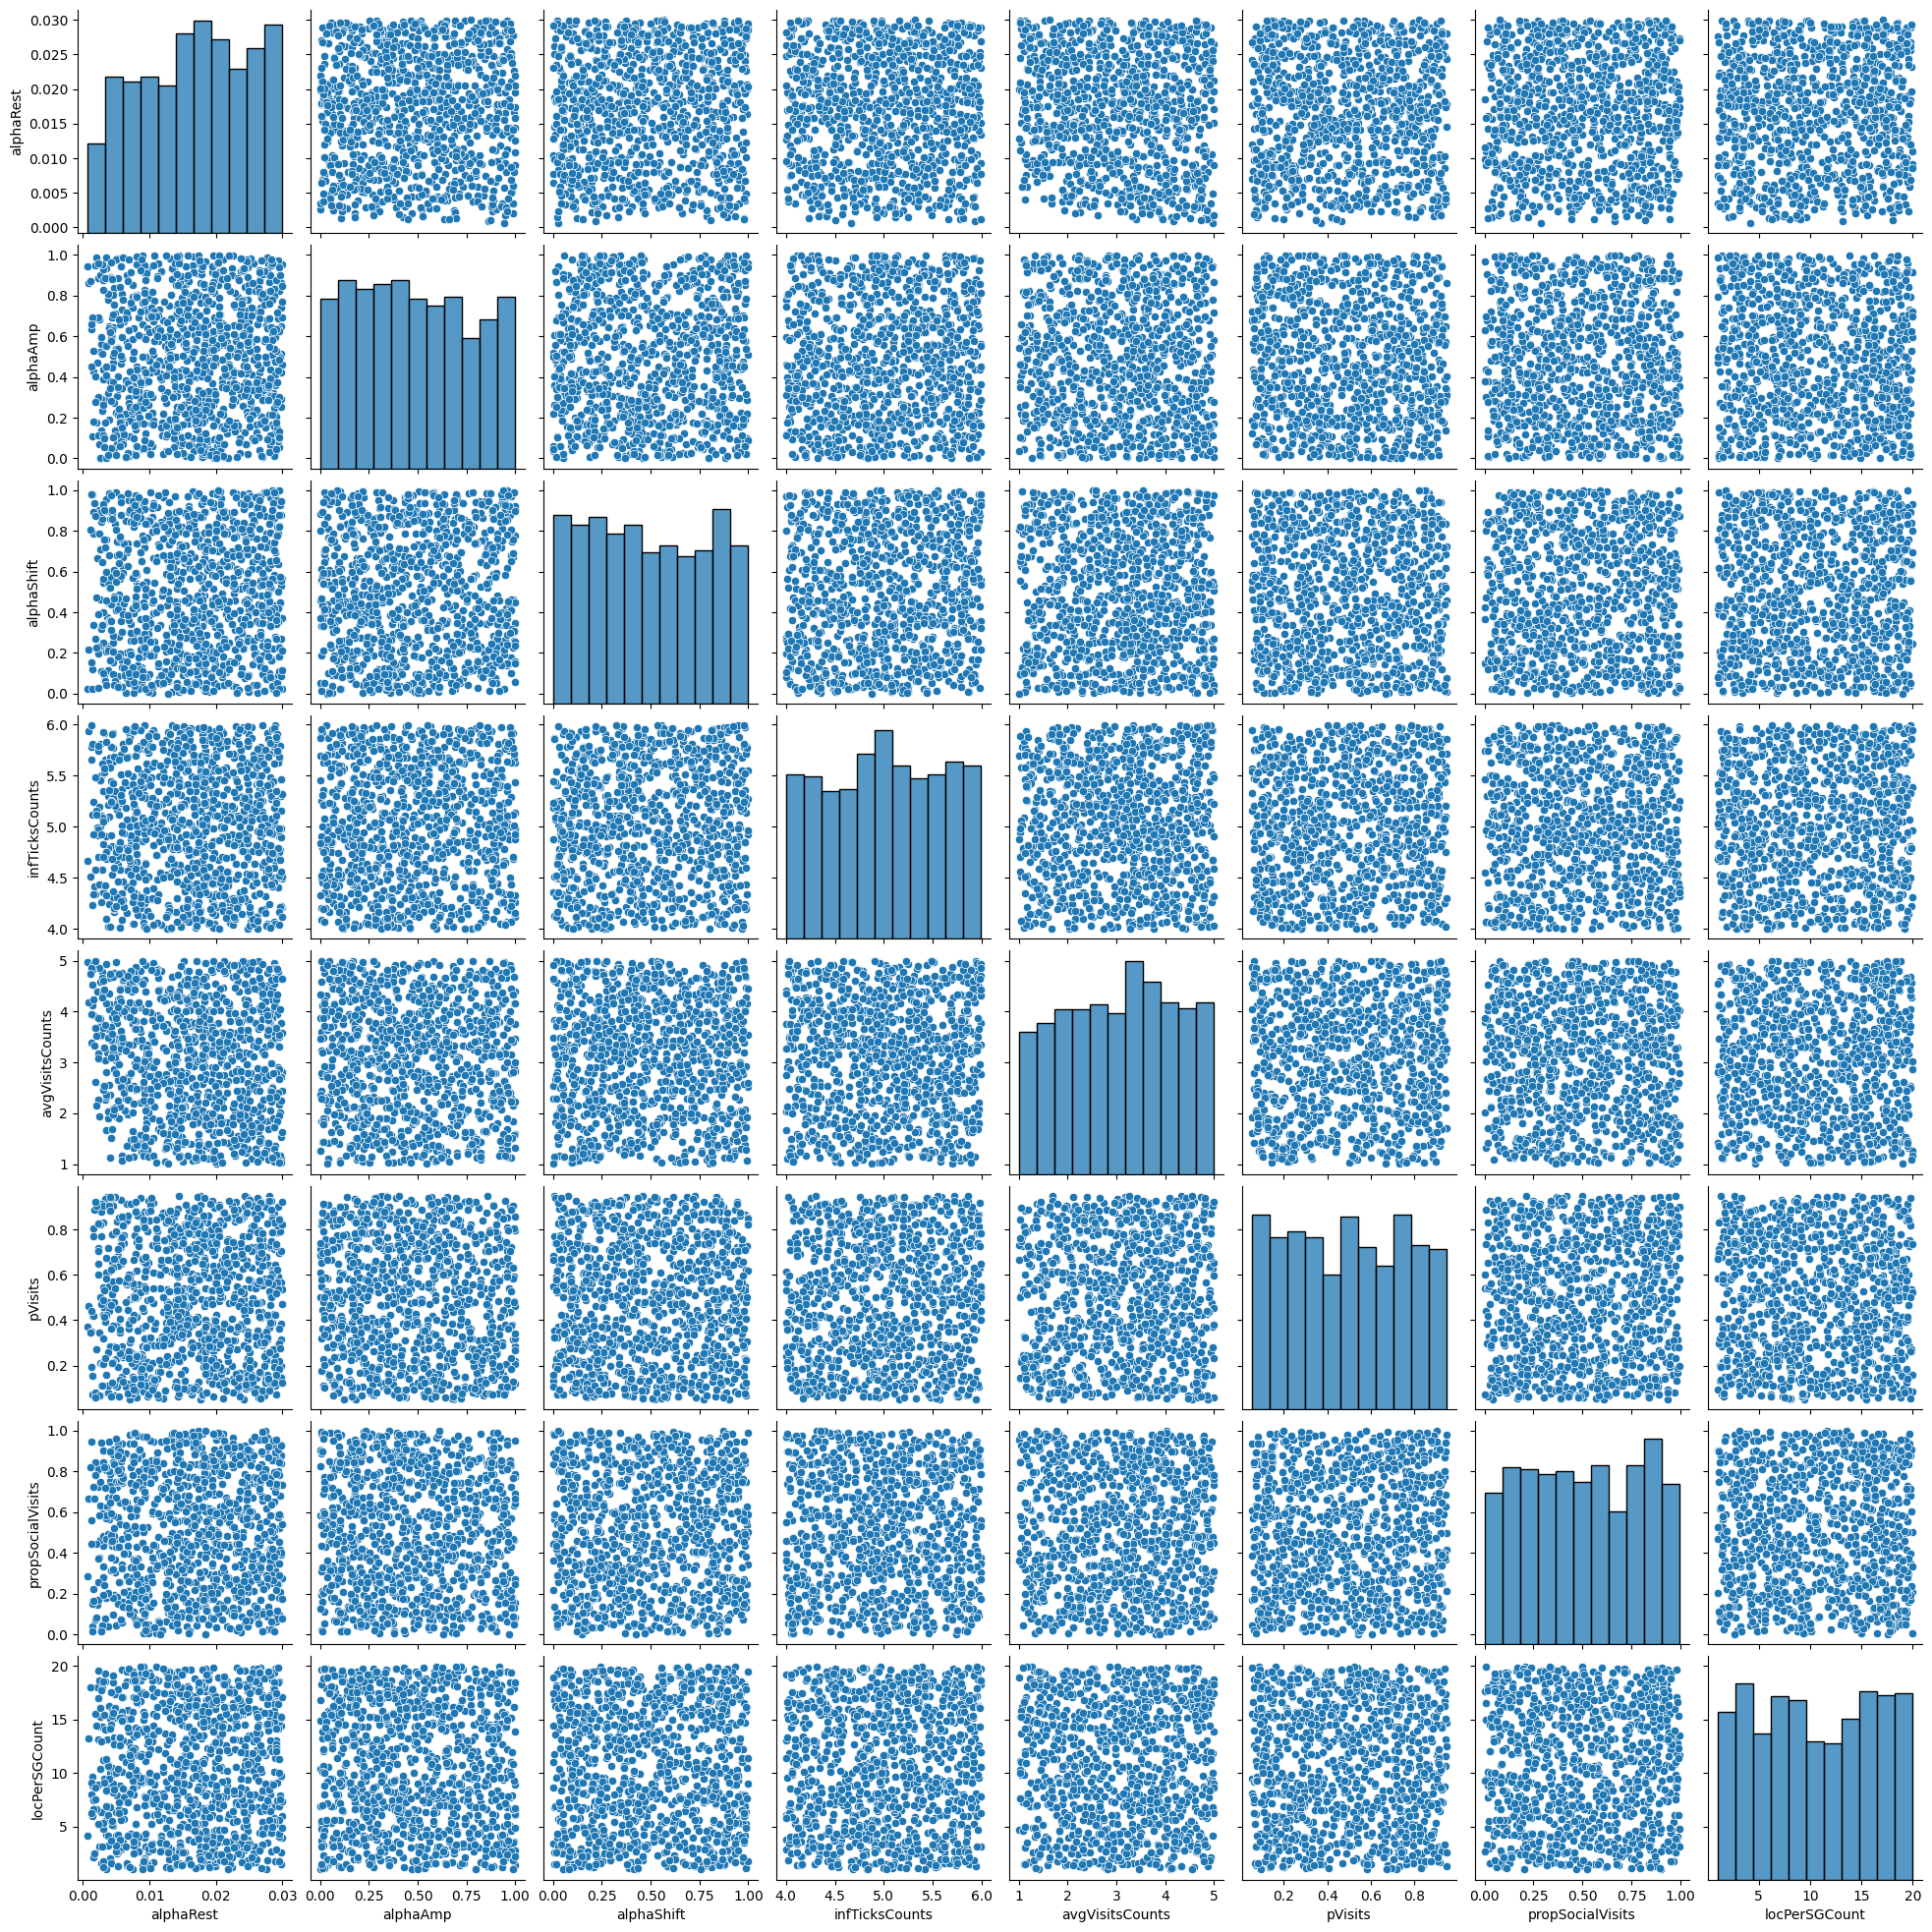

In [10]:
# to show that training set uniformly covers space
print("Displaying Pairplot for (Abbreviatd) Training Data")
sns.pairplot(Xtrain_df)

## Modeling

### Baseline: Multiple Linear Regression

In [11]:
print("N:", number_data_points)
Xtrain, Xtest, Ytrain, Ytest = reset_data(num=number_data_points, res_var=response_var)

N: 1000


In [12]:
# test a multiple linear regression model
mlr = LinearRegression()
mlr.fit(Xtrain,Ytrain)
Ypred_mlr = mlr.predict(Xtest)

print("MSE:", mean_squared_error(Ytest, Ypred_mlr))

MSE: 0.0075696709688511925


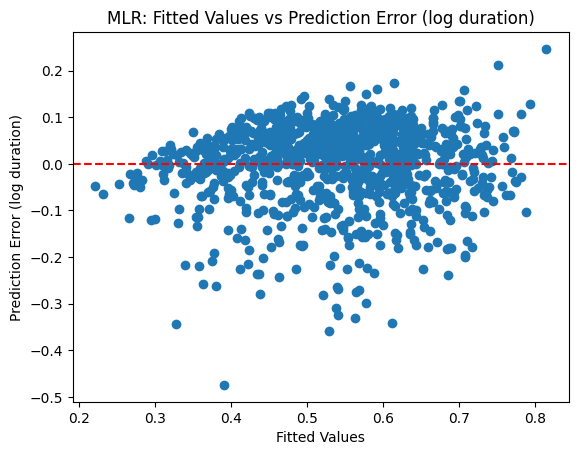

In [13]:
error_mlr = Ypred_mlr - Ytest

plt.scatter(Ypred_mlr, error_mlr)
plt.title(f"MLR: Fitted Values vs Prediction Error ({response_var})")
plt.xlabel("Fitted Values")
plt.axhline(y=0, color='red', linestyle='--')
plt.ylabel(f"Prediction Error ({response_var})")
plt.show()

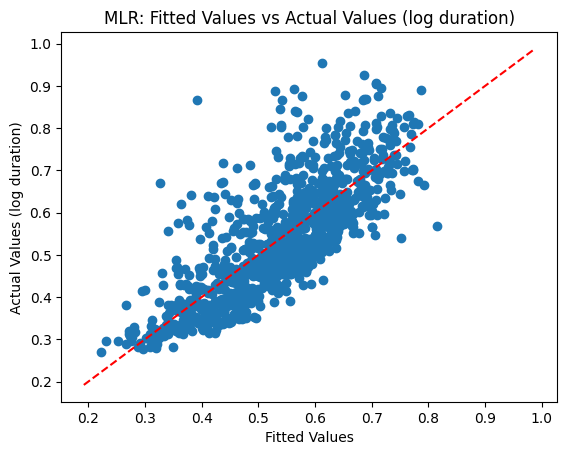

In [14]:
# Fitted Values vs Actual Values

plt.scatter(Ypred_mlr, Ytest)
plt.title(f"MLR: Fitted Values vs Actual Values ({response_var})")
plt.xlabel("Fitted Values")
plt.ylabel(f"Actual Values ({response_var})")

# to add a y = x line
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
range_max = max(x_max, y_max)
range_min = min(x_min, y_min)
plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line

plt.show()

### GP: One-Dimensional Input

*Possible predictor variables*

alphaRest, alphaAmp, alphaShift, infTicksCounts, avgVisitsCounts, pVisits, propSocialVisits, locperSGCount*

In [15]:
# choose predictor variable
pred_var = 'alphaAmp'

In [16]:
number_data_points = 100

Xtrain_df, Xtest_df, Ytrain_df, Ytest_df = reset_data(num=number_data_points, res_var=response_var, df = True)

In [17]:
# only use one input variable
Xtrain = Xtrain_df[pred_var].to_numpy().reshape(-1, 1)
Xtest = Xtest_df[pred_var].to_numpy().reshape(-1,1)

Ytrain = Ytrain_df
Ytest = Ytest_df

# form complete training data array to help with sorting
XYtrain = np.column_stack((Xtrain, Ytrain))

In [18]:
# create model

simple_mod = gpflow.models.GPR(
    data=(XYtrain[:, 0].reshape(-1, 1), XYtrain[:, 1].reshape(-1, 1)),
    kernel=gpflow.kernels.Matern12(),  
)

# assign function variance to be ~0
simple_mod.likelihood.variance.assign(1e-5)
gpflow.set_trainable(simple_mod.likelihood.variance, False)

print("Noise variance:", simple_mod.likelihood.variance.numpy())  # Should print 1e-5


# train the model
opt = gpflow.optimizers.Scipy()
opt.minimize(simple_mod.training_loss, simple_mod.trainable_variables)

Noise variance: 1.0000000000000004e-05


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 33.75894555430102
        x: [-3.782e+00 -9.778e-01]
      nit: 13
      jac: [-7.951e-06  1.472e-06]
     nfev: 21
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [19]:
simple_mod

<gpflow.models.gpr.GPR object at 0x177d84220>
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.319273  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0225258 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 1e-05     │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

In [20]:
f_mean, _ = simple_mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
y_mean, y_var = simple_mod.predict_y(Xtest)

## 95% confidence intervals
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

In [21]:
# add to x test
XYalltest = np.column_stack((Xtest, y_mean, y_lower, y_upper, y_var, f_mean))

# sorting by X column 
XYtrain_sorted = XYtrain[XYtrain[:,0].argsort()] # sort on xs
XYalltest_sorted = XYalltest[XYalltest[:,0].argsort()] # sort on x test

In [22]:
# now separate for ease of plotting

# for training data
Xtrain = XYtrain_sorted[:,0]
Ytrain = XYtrain_sorted[:,1]

# for X test and predictions
Xtest = XYalltest_sorted[:,0]
Ytest = XYalltest_sorted[:,1]
y_lower = XYalltest_sorted[:,2]
y_upper = XYalltest_sorted[:,3]
y_var = XYalltest_sorted[:,4]
f_mean = XYalltest_sorted[:,5]

# set boundary at 0?
#y_lower = np.maximum(y_lower, 0)

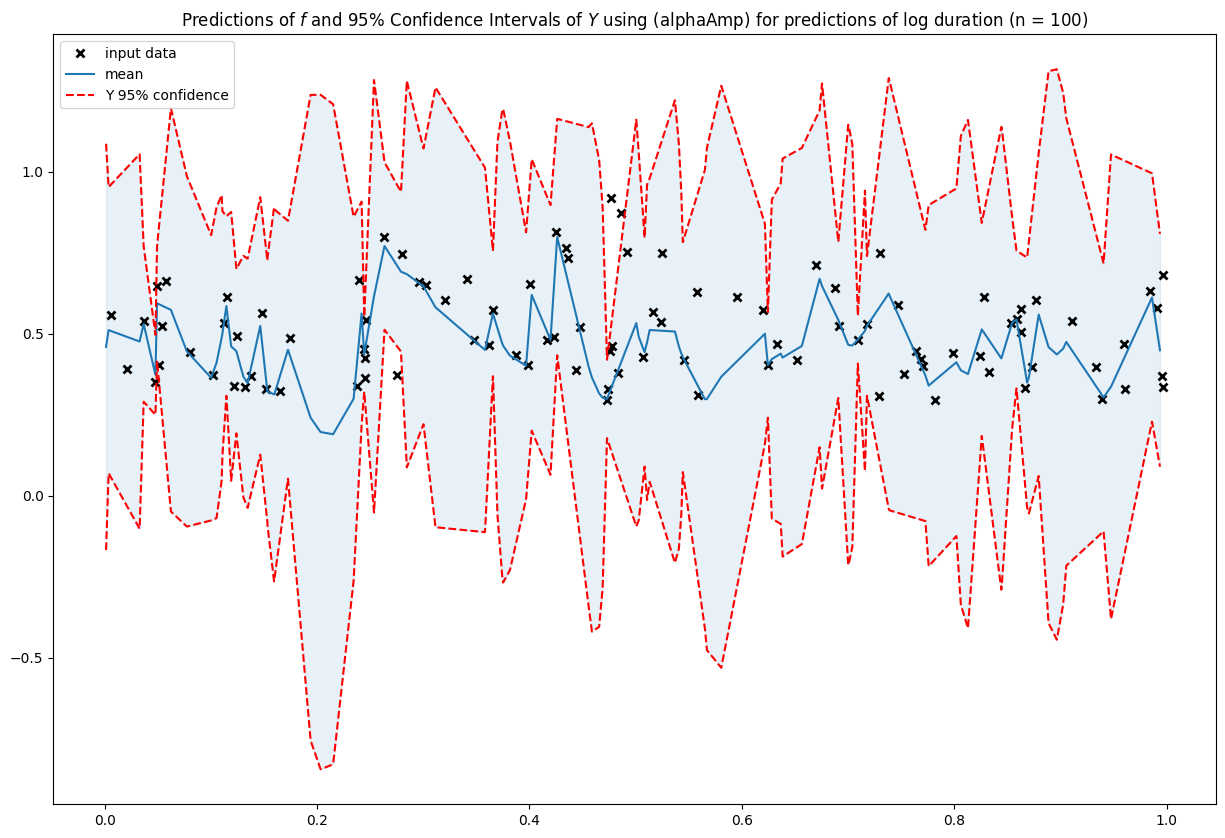

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(Xtrain, Ytrain, "kx", mew=2, label="input data")

plt.plot(Xtest, f_mean, "-", color="C0", label="mean")

plt.plot(Xtest, y_lower, "--", color="red", label="Y 95% confidence")
plt.plot(Xtest, y_upper, "--", color="red")
plt.fill_between(
    Xtest, y_lower, y_upper, color="C0", alpha=0.1)

plt.legend()
plt.title(f"Predictions of $f$ and 95% Confidence Intervals of $Y$ using ({pred_var}) for predictions of {response_var} (n = {number_data_points})")
plt.show()

### GP: N-Dimensional Input

In [24]:
number_data_points = 2000
print("N:", number_data_points)
Xtrain, Xtest, Ytrain, Ytest = reset_data(num=number_data_points, res_var=response_var)

N: 2000


In [25]:
# GP: 
# takes ~40s with 2000

# create model: use matern kernel with smoothness parameter = 1/2
mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(),) 

# assign function variance to be ~ 0
mod.likelihood.variance.assign(1e-5)
gpflow.set_trainable(mod.likelihood.variance, False)

print("Noise variance:", simple_mod.likelihood.variance.numpy())  # Should print 1e-5

# train the model
opt = gpflow.optimizers.Scipy()
opt.minimize(mod.training_loss, mod.trainable_variables)

Noise variance: 1.0000000000000004e-05


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1244.4387945834424
        x: [ 1.969e+02  4.968e+00]
      nit: 42
      jac: [-1.469e-06  3.925e-05]
     nfev: 60
     njev: 60
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [26]:
f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
y_mean, y_var = mod.predict_y(Xtest)

## 95% confidence intervals for y
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

##### Plotting GP

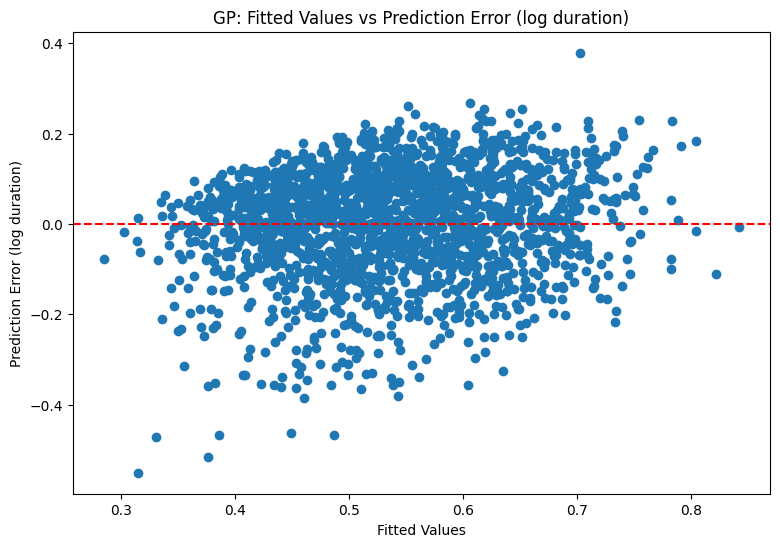

MSE: 0.014135357895097088
RMSE: 0.11889221124656185
Back-transformed RMSE 1.126248514822032
nRMSE: 0.2210418452606476
Mean: 0.5378719631405846


In [27]:
# Fitted Values vs Prediction Error (standardized duration)
error = y_mean - Ytest

plt.figure(figsize=(9, 6))
plt.scatter(y_mean, error)
plt.title(f"GP: Fitted Values vs Prediction Error ({response_var})")
plt.xlabel("Fitted Values")
plt.ylabel(f"Prediction Error ({response_var})")

plt.axhline(y=0, color='red', linestyle='--')

plt.show()

mse = mean_squared_error(Ytest, y_mean)
rmse = mean_squared_error(Ytest, y_mean, squared=False)
bt_rmse = np.exp(mean_squared_error(Ytest, y_mean, squared=False))
nrmse = rmse / np.mean(y_mean)

print("MSE:", mse)
print("RMSE:", rmse)
print("Back-transformed RMSE", bt_rmse)
print("nRMSE:", nrmse)
print("Mean:", np.mean(y_mean))


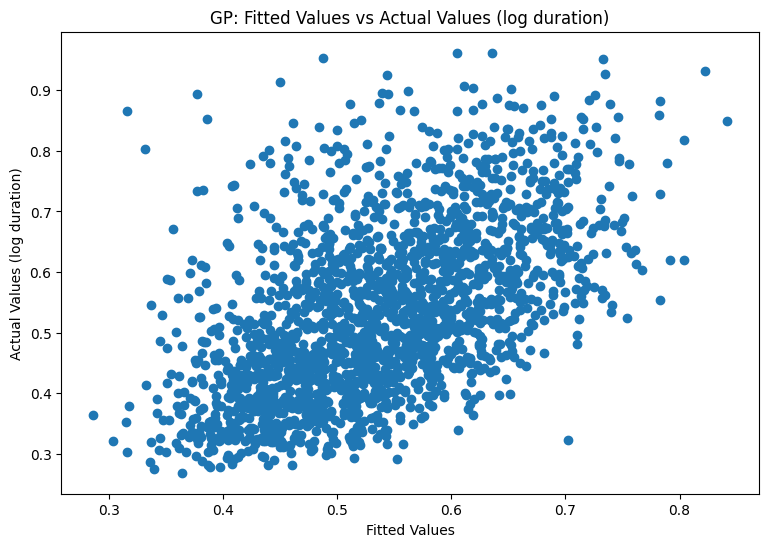

In [28]:
# Fitted Values vs Actual Values
plt.figure(figsize=(9, 6))
plt.scatter(y_mean, Ytest)
plt.title(f"GP: Fitted Values vs Actual Values ({response_var})")
plt.xlabel("Fitted Values")
plt.ylabel(f"Actual Values ({response_var})")

# to add a y = x line
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
range_max = max(x_max, y_max)
range_min = min(x_min, y_min)
#plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line

plt.show()

## Modeling N-dimensional GP Results for 3 Outputs

### Functions

In [29]:
def make_ND_gp(res_var, number_data_points):
    
    # reset data
    Xtrain, Xtest, Ytrain, Ytest = reset_data(number_data_points, res_var)

    # create model
    mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(),) 

    # set variance to 0
    mod.likelihood.variance.assign(1e-5)
    gpflow.set_trainable(mod.likelihood.variance, False)

    # train model
    opt = gpflow.optimizers.Scipy()
    opt.minimize(mod.training_loss, mod.trainable_variables)

    return mod, Xtest, Ytest

In [30]:
def plot_ND_gp(model, res_var, Xtest, Ytest):
    
    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    ## 95% confidence intervals for y
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    #print("MSE ({res_var}):", mean_squared_error(Ytest, y_mean))
    #print("RMSE ({res_var}):", mean_squared_error(Ytest, y_mean, squared=False))
    #print("Back-transformed RMSE ({res_var}):", np.exp(mean_squared_error(Ytest, y_mean, squared=False)))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

    error = y_mean - Ytest

    axes[0].scatter(y_mean, error)
    axes[0].set_title(f"GP: Fitted Values vs Prediction Error ({res_var})")
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel(f"Prediction Error ({res_var})")
    axes[0].axhline(y=0, color='red', linestyle='--')

    axes[1].scatter(y_mean, Ytest)
    axes[1].set_title(f"GP: Fitted Values vs Actual Values ({res_var})")
    axes[1].set_xlabel("Fitted Values")
    axes[1].set_ylabel(f"Actual Values ({res_var})")

    # to add a y = x line
    x_min, x_max = axes[1].get_xlim()
    y_min, y_max = axes[1].get_ylim()
    range_max = max(x_max, y_max)
    range_min = min(x_min, y_min)
    plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line
    
    plt.tight_layout()
    plt.show()

In [31]:
def add_stats(df, model, res_var, Xtest, Ytest, num = number_data_points):

    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    mse = mean_squared_error(Ytest, y_mean)
    rmse = mean_squared_error(Ytest, y_mean, squared=False)
    if res_var == 'log duration':
        bt_rmse = np.exp(mean_squared_error(Ytest, y_mean, squared=False))
    else:
        bt_rmse = np.NaN

    nrmse = rmse / np.mean(Ytest)
    
    new_row = pd.DataFrame([{
        'Response Variable': str(res_var), 
        'N': int(num),
        'MSE': float(mse), 
        'RMSE': float(rmse), 
        'Back-transformed RMSE': float(bt_rmse),
        'Normalized RMSE': float(nrmse)

    }])
    
    df = pd.concat([df, new_row], ignore_index=True)

    return df

In [32]:
# initialize empty dataframe

results = pd.DataFrame({
    'Response Variable': pd.Series(dtype='str'),
    'N': pd.Series(dtype='int'),
    'MSE': pd.Series(dtype='float'),
    'RMSE': pd.Series(dtype='float'),
    'Back-transformed RMSE': pd.Series(dtype='float'),
    'Normalized RMSE': pd.Series(dtype='float')
})

### Implementation

In [33]:
# clear data from results
results = results.iloc[0:0]

In [34]:
logdur_gp, logdur_Xtest, logdur_Ytest = make_ND_gp('log duration', 2000)
epsize_gp, epsize_Xtest, epsize_Ytest = make_ND_gp('epidemicSize', 2000)
maxinc_gp, maxinc_Xtest, maxinc_Ytest = make_ND_gp('maxIncidence', 2000)

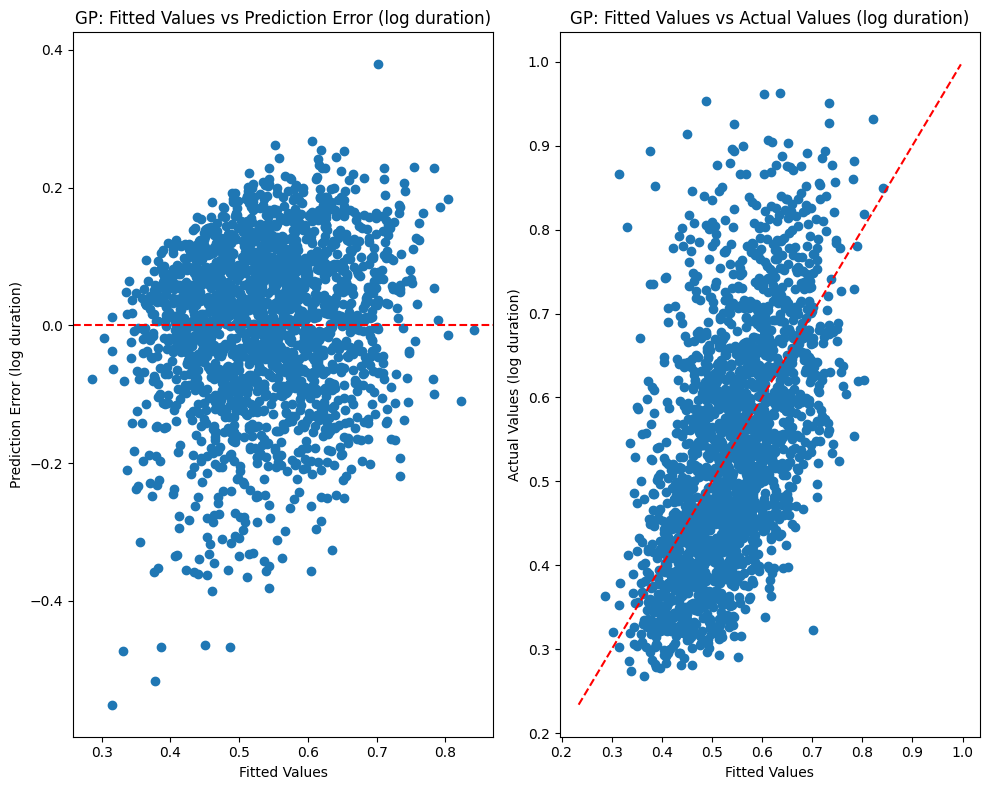

Response Variable     N       MSE      RMSE  Back-transformed RMSE  \
0      log duration  5000  0.014135  0.118892               1.126249   

   Normalized RMSE  
0         0.222219

In [35]:
plot_ND_gp(model = logdur_gp, res_var='log duration', Xtest = logdur_Xtest, Ytest = logdur_Ytest)
results = add_stats(df=results, model = logdur_gp, res_var = 'log duration', Xtest = logdur_Xtest, Ytest = logdur_Ytest, num = 5000)
results

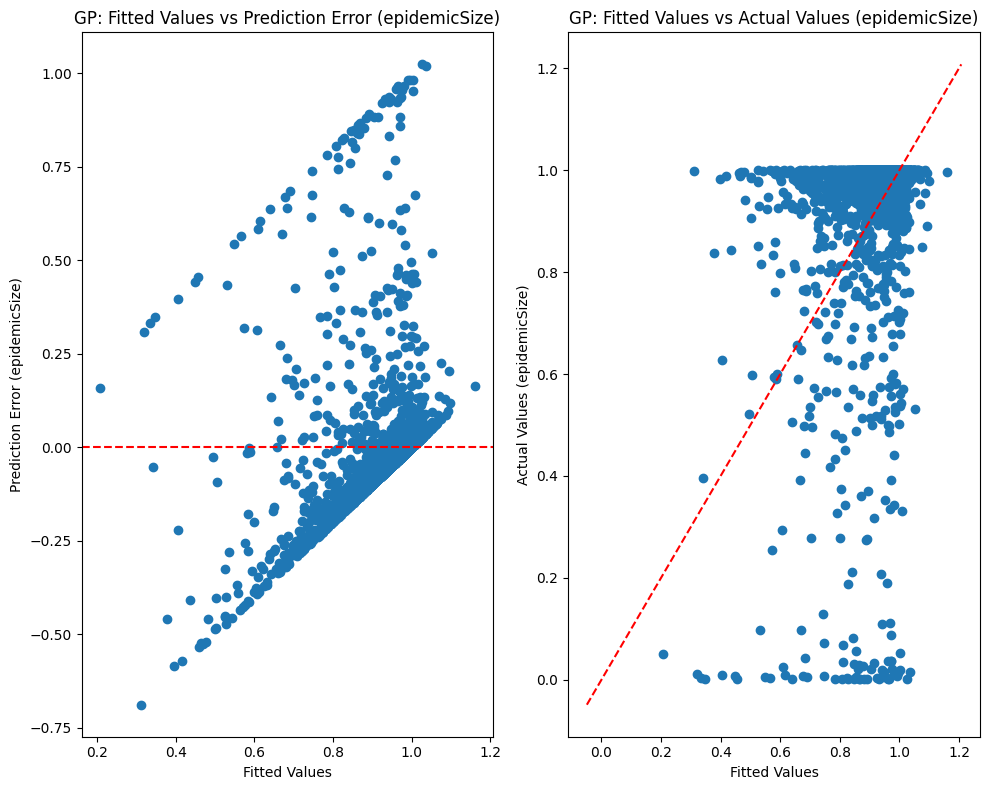

Response Variable     N       MSE      RMSE  Back-transformed RMSE  \
0      log duration  5000  0.014135  0.118892               1.126249   
1      epidemicSize  5000  0.038711  0.196751                    NaN   

   Normalized RMSE  
0         0.222219  
1         0.213964

In [36]:
plot_ND_gp(model = epsize_gp, res_var='epidemicSize', Xtest = epsize_Xtest, Ytest = epsize_Ytest)
results = add_stats(df=results, model = epsize_gp, res_var = 'epidemicSize', Xtest = epsize_Xtest, Ytest = epsize_Ytest, num = 5000)
results

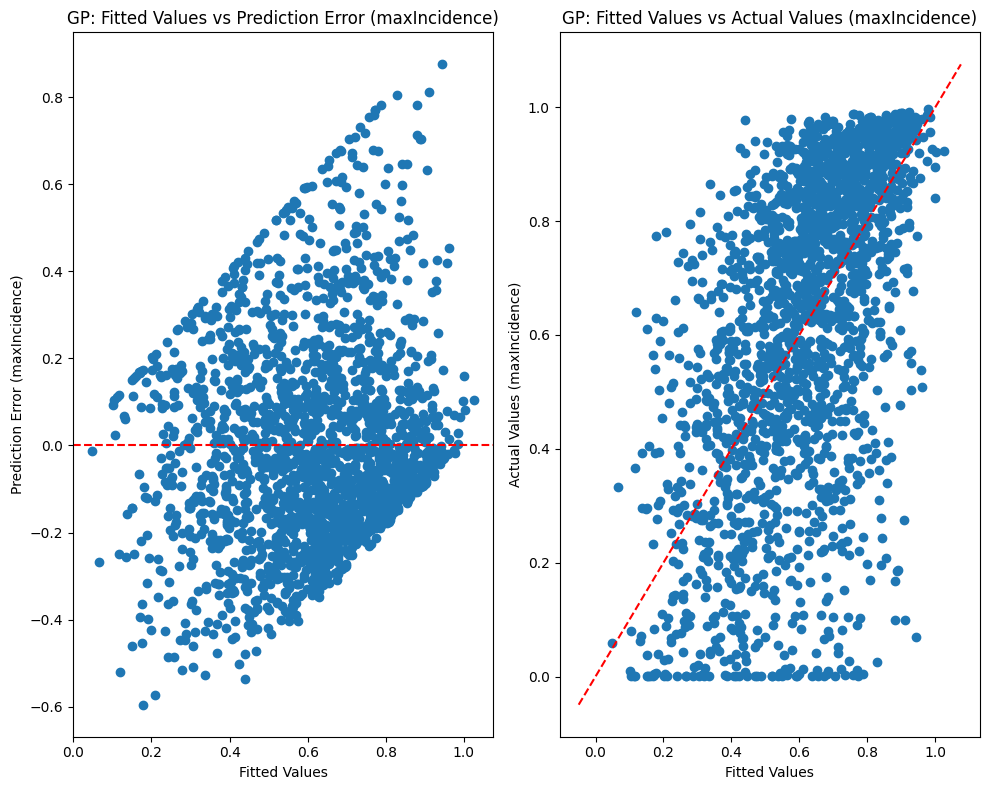

Response Variable     N       MSE      RMSE  Back-transformed RMSE  \
0      log duration  5000  0.014135  0.118892               1.126249   
1      epidemicSize  5000  0.038711  0.196751                    NaN   
2      maxIncidence  5000  0.053540  0.231388                    NaN   

   Normalized RMSE  
0         0.222219  
1         0.213964  
2         0.374167

In [37]:
plot_ND_gp(model = maxinc_gp, res_var='maxIncidence', Xtest = maxinc_Xtest, Ytest = maxinc_Ytest)
results = add_stats(df=results, model = maxinc_gp, res_var = 'maxIncidence', Xtest = maxinc_Xtest, Ytest = maxinc_Ytest, num = 5000)
results

In [38]:
results = results.iloc[0:0]
n_list = [100, 500, 1000, 2000, 5000]

for n in n_list:
    logdur_gp, logdur_Xtest, logdur_Ytest = make_ND_gp('log duration', n)
    results = add_stats(df=results, model = logdur_gp, res_var = 'log duration', Xtest = logdur_Xtest, Ytest = logdur_Ytest, num = n)

    epsize_gp, epsize_Xtest, epsize_Ytest = make_ND_gp('epidemicSize', n)
    results = add_stats(df=results, model = epsize_gp, res_var = 'epidemicSize', Xtest = epsize_Xtest, Ytest = epsize_Ytest, num = n)

    maxinc_gp, maxinc_Xtest, maxinc_Ytest = make_ND_gp('maxIncidence', n)
    results = add_stats(df=results, model = maxinc_gp, res_var = 'maxIncidence', Xtest = maxinc_Xtest, Ytest = maxinc_Ytest, num = n)

results

Response Variable     N       MSE      RMSE  Back-transformed RMSE  \
0       log duration   100  0.020934  0.144687               1.155677   
1       epidemicSize   100  0.082705  0.287584                    NaN   
2       maxIncidence   100  0.080443  0.283625                    NaN   
3       log duration   500  0.016283  0.127606               1.136105   
4       epidemicSize   500  0.053893  0.232149                    NaN   
5       maxIncidence   500  0.065188  0.255319                    NaN   
6       log duration  1000  0.015351  0.123900               1.131902   
7       epidemicSize  1000  0.043758  0.209183                    NaN   
8       maxIncidence  1000  0.058496  0.241859                    NaN   
9       log duration  2000  0.014135  0.118892               1.126249   
10      epidemicSize  2000  0.038711  0.196751                    NaN   
11      maxIncidence  2000  0.053540  0.231388                    NaN   
12      log duration  5000  0.011935  0.109248               1.115439   
13      epidemicSize  5000  0.040903  0.202246                    NaN   
14      maxIncidence  5000  0.047751  0.218520                    NaN   

    Normalized RMSE  
0          0.251931  
1          0.335023  
2          0.546406  
3          0.234663  
4          0.258095  
5          0.431762  
6          0.230264  
7          0.227915  
8          0.396448  
9          0.222219  
10         0.213964  
11         0.374167  
12         0.204845  
13         0.221024  
14         0.353057

In [40]:
results.sort_values('Response Variable')

Response Variable     N       MSE      RMSE  Back-transformed RMSE  \
1       epidemicSize   100  0.082705  0.287584                    NaN   
4       epidemicSize   500  0.053893  0.232149                    NaN   
7       epidemicSize  1000  0.043758  0.209183                    NaN   
10      epidemicSize  2000  0.038711  0.196751                    NaN   
13      epidemicSize  5000  0.040903  0.202246                    NaN   
0       log duration   100  0.020934  0.144687               1.155677   
3       log duration   500  0.016283  0.127606               1.136105   
6       log duration  1000  0.015351  0.123900               1.131902   
9       log duration  2000  0.014135  0.118892               1.126249   
12      log duration  5000  0.011935  0.109248               1.115439   
2       maxIncidence   100  0.080443  0.283625                    NaN   
5       maxIncidence   500  0.065188  0.255319                    NaN   
8       maxIncidence  1000  0.058496  0.241859                    NaN   
11      maxIncidence  2000  0.053540  0.231388                    NaN   
14      maxIncidence  5000  0.047751  0.218520                    NaN   

    Normalized RMSE  
1          0.335023  
4          0.258095  
7          0.227915  
10         0.213964  
13         0.221024  
0          0.251931  
3          0.234663  
6          0.230264  
9          0.222219  
12         0.204845  
2          0.546406  
5          0.431762  
8          0.396448  
11         0.374167  
14         0.353057

## 